# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score,f1_score,auc

from scipy import sparse
import scipy
from scipy.sparse import csr_matrix

/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:33<00:00, 2592.19it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
#BoW
count_vect_bow = CountVectorizer() #in scikit-learn
count_vect_bow.fit(preprocessed_reviews)
print("some feature names ", count_vect_bow.get_feature_names()[:10])
print('='*50)

final_counts = count_vect_bow.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


sparse.save_npz("bowmatrix.npz",final_counts)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [25]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])


sparse.save_npz("bowbigramsmatrix.npz",final_bigram_counts)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

sparse.save_npz("tfidfmatrix.npz",final_tf_idf)

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

In [27]:
# SingleFold function computes Hyperparameter 'alpha' where CV accuracy is highest in single fold in the range of 1 to 30

def mnbSingleFold(X_tr,y_tr,X_cv,y_cv):   
    auc_accuracy={}
    auc_accuracy_tr={}
    auc_train=[]
    auc_cv=[]
    pred_train=pd.DataFrame()
    alpha=np.array([0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0])
    for i in alpha:
            
            # instantiate learning model (for alpha ranging from 10e-4 to 10e+4)
            mnb = MultinomialNB(alpha=i)

            # fitting the model on train data
            mnb.fit(X_tr, y_tr)

            # predict the response on the crossvalidation data
            pred_cv = mnb.predict_log_proba(X_cv)
            # predict the response on the train data
            pred_train = mnb.predict_log_proba(X_tr)
            
            # evaluate CV & train AUC score
            acc = roc_auc_score(y_cv, pred_cv[:,1]) *float(100)
            acc_train = roc_auc_score(y_tr, pred_train[:,1]) *float(100)
            auc_accuracy_tr[i]=acc_train
            auc_accuracy[i]=acc
    auc_train=list(auc_accuracy_tr.values())
    auc_cv=list(auc_accuracy.values())
    plt.title("Hyperparameter plotting against auc score on train & cv data")
    plt.plot(alpha, auc_train, "b--", label="TrainAUC")
    plt.plot(alpha, auc_cv, "g-", label="ValidationAUC")
    plt.ylabel("AUC Score")
    plt.xlabel("Hyperparameter Alpha")
    plt.legend()
    plt.show()
    # We will be choosing 'alpha' where AUC score for CV is highest 
    maxalpha=max(auc_accuracy, key=auc_accuracy.get) 
    print('\nHighest AUC Score for alpha = %d is %d%% using Multinomial NB' % (maxalpha ,auc_accuracy[maxalpha]))
    return(maxalpha,pred_train)

In [28]:
# Fuction to compute alpha value
def mnbNFold(X_train, y_train):
    
    alpha_values=np.array([0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0])
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'roc_auc')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [29]:
# split the dataset into train and  test in the ratio 70:30
def splitData(X,y):
    X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
    # Again split the train data set into cross validation train and cross validation test with 70:30 ratio
    X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)
    print("So 100000 datapoints we have splitted in 3 categories train,cv and test and below are the respective matrix dimensions: ")
    print("Train Data Size: {0}{1} " .format(X_tr.shape,y_tr.shape))
    print("CV Data Size: {0}{1} " .format(X_cv.shape,y_cv.shape))
    print("Test Data Size: {0}{1} " .format(X_test.shape,y_test.shape))
    return(X_tr, X_cv,X_test,X_1,y_tr, y_cv,y_test,y_1)

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [30]:
X_tr_bow,X_cv_bow,X_test_bow,X_1_bow,y_tr, y_cv,y_test,y_1=splitData(final_counts,final['Score'])

So 100000 datapoints we have splitted in 3 categories train,cv and test and below are the respective matrix dimensions: 
Train Data Size: (43008, 54904)(43008,) 
CV Data Size: (18433, 54904)(18433,) 
Test Data Size: (26332, 54904)(26332,) 


In [31]:
# Data-preprocessing: Standardizing the data 
scaler=StandardScaler(with_mean = False)
X_tr_bow_standardized = scaler.fit_transform(X_tr_bow)
X_cv_bow_standardized = scaler.transform(X_cv_bow)
X_test_bow_standardized = scaler.transform(X_test_bow)
X_1_bow_standardized = scaler.transform(X_1_bow)

/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: Data

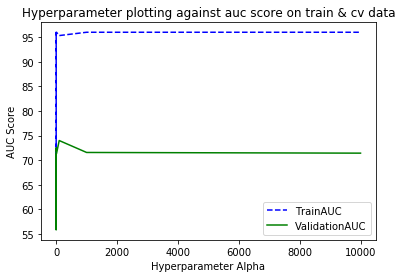


Highest AUC Score for alpha = 10 is 73% using Multinomial NB


In [32]:
# Calculating best alpha using single fold approach
bow_single_fold_mnb_alpha,pred_train=mnbSingleFold(X_tr_bow_standardized,y_tr,X_cv_bow_standardized,y_cv)

In [33]:
#Will get the accuracy on test data using best alpha got while training the model
mnb = MultinomialNB(alpha=bow_single_fold_mnb_alpha)
mnb.fit(X_tr_bow_standardized,y_tr)
pred_score = mnb.predict_log_proba(X_test_bow_standardized)
pred_binary=mnb.predict(X_test_bow_standardized)
singlefold_acc_bow_mnb = roc_auc_score(y_test, pred_score[:,1]) * float(100)


****Test accuracy for Single fold Multionomial NB with alpha= 10 is 73% ****


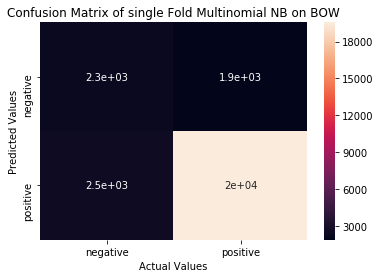

**************************************************
AUC SCORE : 0.7374124922401747


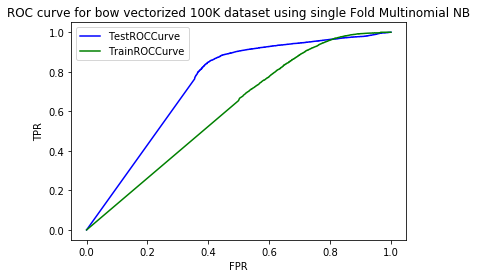

In [34]:
print('\n****Test accuracy for Single fold Multionomial NB with alpha= %d is %d%% ****' % (bow_single_fold_mnb_alpha,singlefold_acc_bow_mnb))
con_matrix_singleFold_mnb_bow=confusion_matrix(y_test,pred_binary)
class_labels=["negative","positive"]
con_matrix_singleFold_mnb_bow_df=pd.DataFrame(con_matrix_singleFold_mnb_bow,columns=class_labels,index=class_labels)
sns.heatmap(con_matrix_singleFold_mnb_bow_df, annot=True)
plt.title("Confusion Matrix of single Fold Multinomial NB on BOW")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

print("*"*50)
fpr, tpr,thresholds = roc_curve(y_test, pred_score[:,1])
singlefold_bow_mnb_auc=auc(fpr,tpr)
fpr_train, tpr_train,thresholds_train = roc_curve(y_tr, pred_train[:,1])
print("AUC SCORE :",singlefold_bow_mnb_auc)
plt.clf()
plt.plot(fpr, tpr,"b-", label="TestROCCurve")
plt.plot(fpr_train, tpr_train,"g-", label="TrainROCCurve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve for bow vectorized 100K dataset using single Fold Multinomial NB')
plt.show()

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [35]:
# Geat all the features from BOW
bow_features=count_vect_bow.get_feature_names()

#Empirical log probability of features given a class, P(x_i|y).
feature_log_probability_bow=mnb.feature_log_prob_ 

#Stored the features names and their corresponding probabilities in  a dataframe
feature_log_probability_bow_df= pd.DataFrame(feature_log_probability_bow, columns =bow_features)
feature_log_probability_bow_df=feature_log_probability_bow_df.T
print(feature_log_probability_bow_df.head(10))

                            0          1
aa                 -11.210461 -10.392763
aaa                -13.120361 -11.050092
aaaa               -13.120361 -14.462202
aaaaa              -13.120361 -14.462202
aaaaaaaaaaaa       -13.120361 -14.462202
aaaaaaaaaaaaaaa    -13.120361 -14.462202
aaaaaaahhhhhh      -13.120361 -11.383112
aaaaaaarrrrrggghhh -10.041271 -14.462202
aaaaaawwwwwwwwww   -13.120361 -11.383112
aaaaah             -13.120361 -11.383112


In [36]:
#Top 10 features from positive class
print("Top 10 features from positive class using bow vectorizer :\n " ,feature_log_probability_bow_df[1].sort_values(ascending=False)[1:10])

Top 10 features from positive class using bow vectorizer :
  great    -6.826512
good     -6.905604
like     -6.963084
love     -7.023309
one      -7.091229
taste    -7.146240
flavor   -7.196015
would    -7.239415
best     -7.245832
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [37]:
#Top 10 features from positive class
print("Top 10 features from negative class using bow vectorizer:\n ",feature_log_probability_bow_df[0].sort_values(ascending=False)[1:10])

Top 10 features from negative class using bow vectorizer:
  would          -6.962503
product        -7.004250
like           -7.009836
taste          -7.027895
bad            -7.222891
even           -7.255219
one            -7.256437
disappointed   -7.257889
money          -7.308499
Name: 0, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [38]:
X_tr_tfidf,X_cv_tfidf,X_test_tfidf,X_1,y_tr,y_cv,y_test,y_1=splitData(final_tf_idf,final['Score'])

So 100000 datapoints we have splitted in 3 categories train,cv and test and below are the respective matrix dimensions: 
Train Data Size: (43008, 51709)(43008,) 
CV Data Size: (18433, 51709)(18433,) 
Test Data Size: (26332, 51709)(26332,) 


In [39]:
# Standardized tfidf data
scaler=StandardScaler(with_mean = False)
X_tr_tfidf_standardized = scaler.fit_transform(X_tr_tfidf)
X_cv_tfidf_standardized = scaler.transform(X_cv_tfidf)
X_test_tfidf_standardized = scaler.transform(X_test_tfidf)

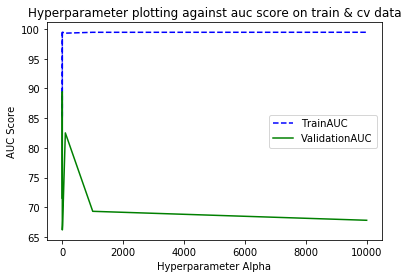


Highest AUC Score for alpha = 100 is 89% using Multinomial NB

****Test accuracy for Single fold Multinomial NB with k= 100 is 88%****


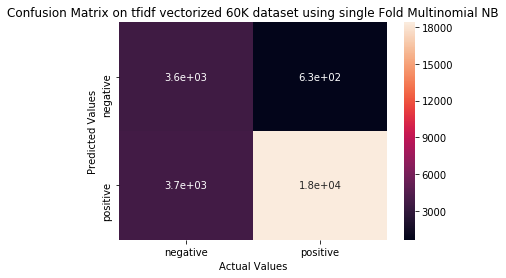

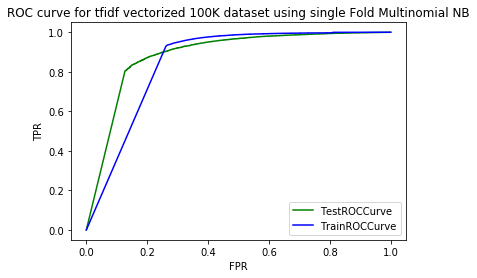

In [40]:
tfidf_single_fold_alpha_mnb,pred_train=mnbSingleFold(X_tr_tfidf_standardized,y_tr,X_cv_tfidf_standardized,y_cv)

mnb_tfidf = MultinomialNB(alpha=tfidf_single_fold_alpha_mnb)
mnb_tfidf.fit(X_tr_tfidf_standardized,y_tr)
pred_score = mnb_tfidf.predict_log_proba(X_test_tfidf_standardized)
pred_binary=mnb_tfidf.predict(X_test_tfidf_standardized)
singlefold_acc_tfidf_mnb = roc_auc_score(y_test,pred_score[:,1]) * float(100)

print('\n****Test accuracy for Single fold Multinomial NB with k= %d is %d%%****' % (tfidf_single_fold_alpha_mnb,singlefold_acc_tfidf_mnb))
con_matrix_singleFold_mnb_tfidf=confusion_matrix(y_test,pred_binary)
class_labels=["negative","positive"]
con_matrix_singleFold_mnb_tfidf_df=pd.DataFrame(con_matrix_singleFold_mnb_tfidf,columns=class_labels,index=class_labels)
sns.heatmap(con_matrix_singleFold_mnb_tfidf_df, annot=True)
plt.title("Confusion Matrix on tfidf vectorized 60K dataset using single Fold Multinomial NB")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

fpr, tpr,thresholds = roc_curve(y_test, pred_score[:,1])
singlefold_tfidf_mnb_auc=auc(fpr,tpr)
fpr_train, tpr_train,thresholds_train = roc_curve(y_tr, pred_train[:,1])
plt.clf()
plt.plot(fpr, tpr,"g-", label="TestROCCurve")
plt.plot(fpr_train, tpr_train,"b-", label="TrainROCCurve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve for tfidf vectorized 100K dataset using single Fold Multinomial NB')
plt.show()

In [41]:
# Geat all the features from BOW
tfidf_features=tf_idf_vect.get_feature_names()
#Empirical log probability of features given a class, P(x_i|y).
feature_log_probability_tfidf=mnb_tfidf.feature_log_prob_ 

feature_log_probability_tfidf_df= pd.DataFrame(feature_log_probability_tfidf, columns =tfidf_features)
feature_log_probability_tfidf_df=feature_log_probability_tfidf_df.T
print(feature_log_probability_tfidf_df.head(10))

                   0          1
aa        -10.943450 -11.129943
aafco     -11.714766 -11.156218
aback     -11.143578 -11.266124
abandon   -11.528858 -11.209640
abandoned -10.321967 -11.644953
abdominal -10.557418 -11.591615
ability   -10.621326 -10.313854
able       -9.561224  -8.818408
able add  -11.151106 -11.015984
able brew -11.714766 -11.193321


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [42]:
#Top 10 features from positive class
print("Top 10 features from positive class using tfidf vectorizer :\n " ,feature_log_probability_tfidf_df[1].sort_values(ascending=False)[1:10])

Top 10 features from positive class using tfidf vectorizer :
  great     -7.596963
good      -7.606272
like      -7.640583
love      -7.785983
one       -7.793332
taste     -7.853725
flavor    -7.888655
would     -7.945788
product   -7.968431
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [43]:
#Top 10 features from negative class
print("Top 10 features from negative class using tfidf vectorizer:\n " ,feature_log_probability_tfidf_df[0].sort_values(ascending=False)[1:10])

Top 10 features from negative class using tfidf vectorizer:
  would          -7.820773
like           -7.861389
taste          -7.929291
product        -7.976929
bad            -8.118786
one            -8.142994
even           -8.184061
would not      -8.190107
disappointed   -8.227469
Name: 0, dtype: float64


# [5.3] Feature Engineering 

In [44]:
# Introducing new feature i.e length of review text along with reviews for modelling
review_length=[len(preprocessed_reviews[i]) for i in range(len(preprocessed_reviews))]
fe_dataset=scipy.sparse.hstack(( final_counts, csr_matrix(review_length).T ))
fe_dataset

<87773x54905 sparse matrix of type '<class 'numpy.int64'>'
	with 2989359 stored elements in COOrdinate format>

In [45]:
# Applying the model on new features achieved through feature engineering to see the model performance
X_tr_bow,X_cv_bow,X_test_bow,X_1_bow,y_tr, y_cv,y_test,y_1=splitData(fe_dataset,final['Score'])
# Data-preprocessing: Standardizing the data 
scaler=StandardScaler(with_mean = False)
X_tr_bow_standardized_fe = scaler.fit_transform(X_tr_bow)
X_cv_bow_standardized_fe = scaler.transform(X_cv_bow)
X_test_bow_standardized_fe = scaler.transform(X_test_bow)
X_1_bow_standardized_fe = scaler.transform(X_1_bow)

So 100000 datapoints we have splitted in 3 categories train,cv and test and below are the respective matrix dimensions: 
Train Data Size: (43008, 54905)(43008,) 
CV Data Size: (18433, 54905)(18433,) 
Test Data Size: (26332, 54905)(26332,) 


/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ushayadu04/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: Data

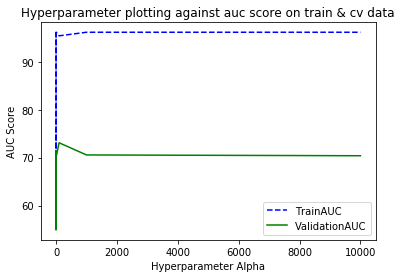


Highest AUC Score for alpha = 10 is 73% using Multinomial NB

****Test accuracy for Single fold Multionomial NB with alpha= 10 is 74% ****


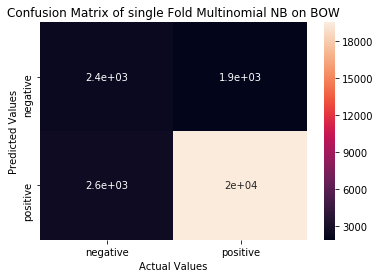

**************************************************
AUC SCORE : 0.7403895601373194


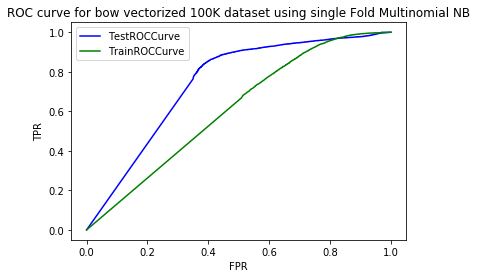

In [46]:
# Calculating best alpha using single fold approach
fe_bow_single_fold_mnb_alpha,pred_train=mnbSingleFold(X_tr_bow_standardized_fe,y_tr,X_cv_bow_standardized_fe,y_cv)

#Will get the accuracy on test data using best alpha got while training the model
mnb = MultinomialNB(alpha=fe_bow_single_fold_mnb_alpha)
mnb.fit(X_tr_bow_standardized_fe,y_tr)
pred_score = mnb.predict_log_proba(X_test_bow_standardized_fe)
pred_binary=mnb.predict(X_test_bow_standardized_fe)
fe_singlefold_acc_bow_mnb = roc_auc_score(y_test, pred_score[:,1]) * float(100)


print('\n****Test accuracy for Single fold Multionomial NB with alpha= %d is %d%% ****' % (fe_bow_single_fold_mnb_alpha,fe_singlefold_acc_bow_mnb))
fe_con_matrix_singleFold_mnb_bow=confusion_matrix(y_test,pred_binary)
class_labels=["negative","positive"]
fe_con_matrix_singleFold_mnb_bow_df=pd.DataFrame(fe_con_matrix_singleFold_mnb_bow,columns=class_labels,index=class_labels)
sns.heatmap(fe_con_matrix_singleFold_mnb_bow_df, annot=True)
plt.title("Confusion Matrix of single Fold Multinomial NB on BOW")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

print("*"*50)
fpr, tpr,thresholds = roc_curve(y_test, pred_score[:,1])
fe_singlefold_bow_mnb_auc=auc(fpr,tpr)
fpr_train, tpr_train,thresholds_train = roc_curve(y_tr, pred_train[:,1])
print("AUC SCORE :",fe_singlefold_bow_mnb_auc)
plt.clf()
plt.plot(fpr, tpr,"b-", label="TestROCCurve")
plt.plot(fpr_train, tpr_train,"g-", label="TrainROCCurve")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve for bow vectorized 100K dataset using single Fold Multinomial NB')
plt.show()

# [6] Conclusions

In [47]:
from prettytable import PrettyTable
import random
x = PrettyTable(["Vectorizer", "Model", "Hyperparameter alpha ","AUC"])
x.add_row(["BOW","MultiNomial NaiveBayes",bow_single_fold_mnb_alpha,singlefold_bow_mnb_auc])
x.add_row(["------------------","------------------","------------------","------------------"])
x.add_row(["tfidf","MultiNomial NaiveBayes",tfidf_single_fold_alpha_mnb,singlefold_tfidf_mnb_auc])
x.add_row(["------------------","------------------","------------------","------------------"])
x.add_row(["BOW","MultiNomial NaiveBayes \n via Feature Engineering",fe_bow_single_fold_mnb_alpha,fe_singlefold_bow_mnb_auc])
print(x)

+--------------------+--------------------------+-----------------------+--------------------+
|     Vectorizer     |          Model           | Hyperparameter alpha  |        AUC         |
+--------------------+--------------------------+-----------------------+--------------------+
|        BOW         |  MultiNomial NaiveBayes  |          10.0         | 0.7374124922401747 |
| ------------------ |    ------------------    |   ------------------  | ------------------ |
|       tfidf        |  MultiNomial NaiveBayes  |         100.0         | 0.8863648002596138 |
| ------------------ |    ------------------    |   ------------------  | ------------------ |
|        BOW         | MultiNomial NaiveBayes   |          10.0         | 0.7403895601373194 |
|                    |  via Feature Engineering |                       |                    |
+--------------------+--------------------------+-----------------------+--------------------+
